In [2]:
import cv2, os
import numpy as np

import importlib

import handling
import utils

In [3]:
importlib.reload(handling)

<module 'handling' from '/mnt/d/uni/THESIS/app/handling.py'>

In [4]:
importlib.reload(utils)

<module 'utils' from '/mnt/d/uni/THESIS/app/utils.py'>

In [5]:
path_shared = "/mnt/d/uni/THESIS/09816"

path_ecad = path_shared+"/VE0D6A800067E3.mrxs"
wrap_ecad = handling.mrxs_wrapper(path_ecad)
path_p63 = path_shared+"/VE0D6A800067E4.mrxs"
wrap_p63 = handling.mrxs_wrapper(path_p63)
path_sish = path_shared+"/VE0D6A800069B1.mrxs"
wrap_sish = handling.mrxs_wrapper(path_sish)

In [6]:
utils.match_samples(wrap_ecad, wrap_p63)

[(0, 3), (2, 1), (3, 0), (1, 2), (4, 4)]

In [7]:
import matplotlib.pyplot as plt
def imshow(arr):
    plt.axis('off')
    if len(arr.shape) == 2:
        plt.imshow(arr, cmap='gray')
        return
    if arr.shape[2] == 1:
        plt.imshow(arr, cmap='gray')
        return
    plt.imshow(arr)

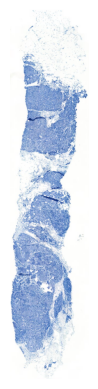

In [8]:
imshow(wrap_sish.obj_at_lvl([5],6))

In [9]:
wrap_sish.image.dimensions

(177152, 417024)

(145, 1408, 143, 127)
(317, 1359, 165, 147)
(120, 1227, 159, 146)
(329, 1203, 136, 147)
(390, 439, 92, 314)


True

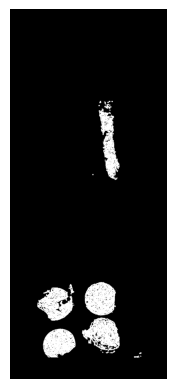

In [10]:
def alpha_fix(arr):
    if not arr[3]:
        return np.array([255,255,255,255], dtype=np.uint8)
    return arr

lowlevel = np.array(wrap_ecad.image.read_region((0,0), 7, wrap_ecad.image.level_dimensions[7]))
lowlevel = np.apply_along_axis(alpha_fix, 2, lowlevel) # whites out "hole du corruption" and other alpha-0 regions
edges = cv2.Canny(lowlevel, threshold1=32, threshold2=48)
edges = cv2.dilate(edges, np.full((3,3),1))
contours,hierarchy = cv2.findContours(edges,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
out = lowlevel.copy()
for cnt in contours:
    if cv2.contourArea(cnt) < 2000:
        cv2.drawContours(out, [cnt], 0, (0,0,255),3)
    else:
        print(cv2.boundingRect(cnt))
        cv2.drawContours(out, [cnt], 0, (0,255,0), 3)
# out = cv2.erode(out, np.full((5,5),1))
# out = cv2.dilate(out, np.full((7,7),1))
imshow(edges)
cv2.imwrite("edges.png", edges)

# UTILS

In [19]:
el1 = 1
el2 = 2
lvl = 5

src1 = wrap_ecad.obj_at_lvl([el1], lvl)
src2 =  wrap_p63.obj_at_lvl([el2], lvl)
src2 = src2[-1::-1, -1::-1, :]
    
gray1 = cv2.cvtColor(src1, cv2.COLOR_RGBA2GRAY)
gray2 = cv2.cvtColor(src2, cv2.COLOR_RGBA2GRAY)

In [20]:
(cc, warp_matrix) = utils.get_warp(gray1, gray2)
cc

0.6441408121168557

In [21]:
src2_aligned = cv2.warpPerspective(src2, warp_matrix, (src1.shape[1], src1.shape[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)

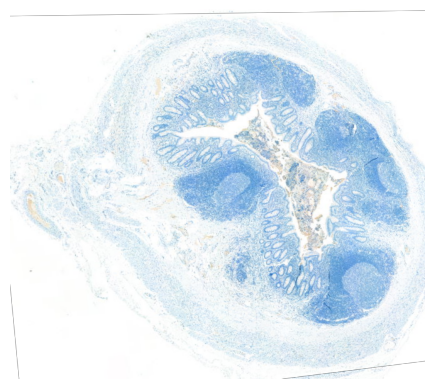

In [24]:
imshow(src1)
imshow(src2)
imshow(src2_aligned)

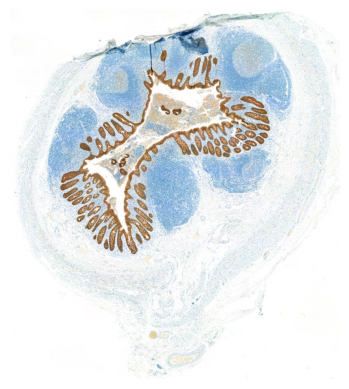

In [26]:
src1_rot90 = np.rot90(src1, k=1)
imshow(src1_rot90)

In [27]:
for rota in range(0, 4):
    gray1_rot = np.rot90(gray1, k=rota)
    try:
        (cc, warp_matrix) = utils.get_warp(gray1_rot, gray2, iters=512)
        print(f"at {rota*90} degrees correlation is {cc}")
    except:
        print(f"at {rota*90} degrees did not converge")

at 0 degrees correlation is 0.6431349498272705
at 90 degrees correlation is 0.28806268505738564
at 180 degrees correlation is 0.20049983669237015
at 270 degrees correlation is 0.2789230944934922


In [28]:
def check_rota(obj1, obj2):
    gray1 = cv2.cvtColor(obj1, cv2.COLOR_RGBA2GRAY)
    gray2 = cv2.cvtColor(obj2, cv2.COLOR_RGBA2GRAY)
    for rota in range(0, 4):
        gray1_rot = np.rot90(gray1, k=rota)
        try:
            (cc, warp_matrix) = utils.get_warp(gray1_rot, gray2, iters=512)
            print(f"at {rota*90} degrees correlation is {cc}")
        except:
            print(f"at {rota*90} degrees did not converge")

# Low-level approx

In [208]:
el1 = 2
el2 = 1
lvl = 4

src1 = wrap_ecad.obj_at_lvl([el1], lvl)
src2 =  wrap_p63.obj_at_lvl([el2], lvl)

gray1 = cv2.cvtColor(src1, cv2.COLOR_RGBA2GRAY)
gray2 = cv2.cvtColor(src2, cv2.COLOR_RGBA2GRAY)

In [202]:
warp_matrix = None
for lvl in [8,7,6,5,4]:
    src1 = wrap_ecad.obj_at_lvl([el1], lvl)
    src2 =  wrap_p63.obj_at_lvl([el2], lvl)
    gray1 = cv2.cvtColor(src1, cv2.COLOR_RGBA2GRAY)
    gray2 = cv2.cvtColor(src2, cv2.COLOR_RGBA2GRAY)
    (cc, warp_matrix) = utils.get_warp(gray1, gray2, base=warp_matrix)
    print(cc)

0.8650045958050575
0.8436870745621701
0.811357713890738
0.7583477477292876
0.6708202220632524


In [83]:
(cc, warp_matrix) = utils.get_warp(gray1, gray2)
cc

0.47605217848069925

In [203]:
src2_aligned = cv2.warpPerspective(src2, warp_matrix, (src1.shape[1], src1.shape[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
cv2.imshow('aligned', src2_aligned)
cv2.waitKey(0)

-1

In [206]:
lvl_new = 2

warp_matrix_scaled = warp_matrix.copy()
warp_matrix_scaled[0:2,2] = wrap_ecad._convert_scale_from_to(warp_matrix[0:2,2], lvl, lvl_new)

large1 = wrap_ecad.obj_at_lvl([el], 2)
large2 = wrap_p63.obj_at_lvl([el], 2)

large2_aligned = cv2.warpPerspective(large2, warp_matrix_scaled, (large1.shape[1], large1.shape[0]), flags=cv2.INTER_LANCZOS4 + cv2.WARP_INVERSE_MAP)

In [207]:
cv2.imshow('target', large1[1500:2000,1500:2000,:])
cv2.imshow('aligned', large2_aligned[1500:2000,1500:2000,:])
cv2.waitKey(0)

-1

# Tile-enhanced alignment ?
ECC at level 4 takes... reasonable time. At level 3 it's impossible. That's where we start tiling and approximating warp matrices across the image

In [94]:
el = 2

warp_matrix = None
for lvl in [8,7,6,5]:
    src1 = wrap_ecad.obj_at_lvl([el], lvl)
    src2 =  wrap_p63.obj_at_lvl([el], lvl)
    gray1 = cv2.cvtColor(src1, cv2.COLOR_RGBA2GRAY)
    gray2 = cv2.cvtColor(src2, cv2.COLOR_RGBA2GRAY)
    (cc, warp_matrix) = utils.get_warp(gray1, gray2, base=warp_matrix)
    print(cc)

0.7442841480771177
0.7654432928582707
0.7455797429729395
0.6857804584302828


In [95]:
wrap_ecad._bounds_at_lvl([el], 4)

{'x': 30592, 'y': 166656, 'h': 680, 'w': 968}

# WHO DIS
Per image, find regions that are brown or not brown. Will use combo info from ecad and p63 on this topic to find locaitons

In [38]:
growth_iter = 10
hit_kernel = np.array([[0,0,0],
                       [0,1,0],
                       [0,0,0]], np.uint8)
miss_kernel = np.array([[1,1,1],
                        [1,0,1],
                        [1,1,1]], dtype=np.uint8)

def mask_dye(img):
    return cv2.inRange(img, (0,8,8), (40,224,160)) + cv2.inRange(img, (155,8,8), (179,224,160))

def expand_mask(mask):
    hit = cv2.morphologyEx(mask, cv2.MORPH_ERODE, hit_kernel)
    miss = cv2.morphologyEx(cv2.bitwise_not(mask), cv2.MORPH_ERODE, miss_kernel)
    hitormiss = cv2.bitwise_and(hit, miss)
    mask = mask - hitormiss
    
    mask = cv2.dilate(mask, np.full((9,9),1))
    for i in range(growth_iter):
        mask = cv2.medianBlur(mask, 7)
    return mask

In [257]:
el = 1
lvl = 3

obj = wrap_p63.obj_at_lvl([el], lvl)
brownreg = obj.copy()
obj = cv2.cvtColor(obj, cv2.COLOR_RGB2HSV)
mask = cv2.inRange(obj, (0,8,8), (40,224,160)) + cv2.inRange(obj, (155,8,8), (179,224,160))
fixed_mask = expand_mask(mask)

brownreg[:,:,2] = np.where(mask, 255, brownreg[:,:,2])
brownreg[:,:,1] = np.where(mask, 0, brownreg[:,:,1])
brownreg[:,:,0] = np.where(mask, 0, brownreg[:,:,0])
cv2.imshow('mask', fixed_mask[mask.shape[0]//4*2:mask.shape[0]//4*3,:])
cv2.waitKey(0)

-1

# Compile into zones

In [35]:
def wrap_mask_at_lvl(wrap, loc, lvl):
    obj = wrap.obj_at_lvl(loc, lvl)
    obj = cv2.cvtColor(obj, cv2.COLOR_RGB2HSV)
    mask = mask_dye(obj)
    mask = expand_mask(mask)
    return mask

In [26]:
utils.match_samples(wrap_ecad, wrap_sish)

[(2, 4), (0, 3), (3, 2), (1, 0), (4, 5)]

In [27]:
utils.match_samples(wrap_p63, wrap_sish)

[(0, 2), (1, 4), (3, 3), (2, 0), (4, 5)]

In [28]:
utils.match_samples(wrap_p63, wrap_ecad)

[(3, 0), (1, 2), (0, 3), (2, 1), (4, 4)]

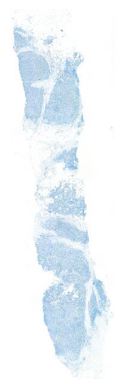

In [32]:
imshow(wrap_p63.obj_at_lvl([4],6))

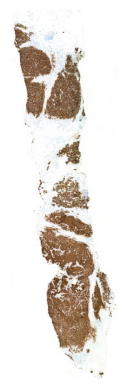

In [33]:
imshow(wrap_ecad.obj_at_lvl([4],6))

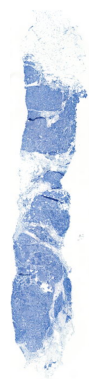

In [34]:
imshow(wrap_sish.obj_at_lvl([5],7))

In [44]:
mask_ecad = wrap_mask_at_lvl(wrap_ecad, [4], 5)
mask_p63 = wrap_mask_at_lvl(wrap_p63, [4], 3)

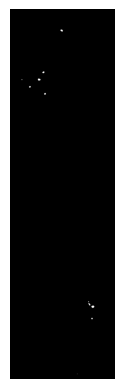

In [45]:
imshow(mask_p63)

In [29]:
check_rota(wrap_ecad.obj_at_lvl([4],6), wrap_sish.obj_at_lvl([5],7))

at 0 degrees correlation is 0.4409646786385607
at 90 degrees correlation is 0.20778786075902725
at 180 degrees correlation is 0.40264487989647063
at 270 degrees did not converge


In [12]:
el1 = 4
el2 = 5

warp_matrix = None
for lvl in [7,6,5,4]:
    src1 = wrap_ecad.obj_at_lvl([el1], lvl)
    src2 = wrap_sish.obj_at_lvl([el2], lvl+1)
    gray1 = cv2.cvtColor(src1, cv2.COLOR_RGBA2GRAY)
    gray2 = cv2.cvtColor(src2, cv2.COLOR_RGBA2GRAY)
    (cc, warp_matrix) = utils.get_warp(gray1, gray2, base=warp_matrix)
    print(cc)
warp_ecad = warp_matrix.copy()

0.5995143608150029
0.6469631134525339
0.5213520163113575
0.345059927402782


In [13]:
warp_matrix = None
for lvl in [7,6,5,4]:
    src1 = wrap_p63.obj_at_lvl([el1], lvl)
    src2 = wrap_sish.obj_at_lvl([el2], lvl+1)
    gray1 = cv2.cvtColor(src1, cv2.COLOR_RGBA2GRAY)
    gray2 = cv2.cvtColor(src2, cv2.COLOR_RGBA2GRAY)
    (cc, warp_matrix) = utils.get_warp(gray2, gray1, base=warp_matrix)
    print(cc)
warp_p63 = warp_matrix.copy()

0.7071554367167531
0.666689276658428
0.5297450287162944
0.27985589523650584


In [29]:
warp_p63 = warp_matrix.copy()
warp_p63[0][2] -= 200
warp_p63[1][2] += 350

In [30]:
p63_aligned = cv2.warpPerspective(src1, warp_p63, (int(src2.shape[1]*1.2), src2.shape[0]*1), flags=cv2.INTER_LANCZOS4 + cv2.WARP_INVERSE_MAP)[:,:-1,:]

In [37]:
box_color = (64,255,128)

True

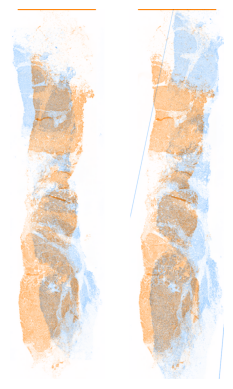

In [41]:
src1_pad = np.concatenate([np.full((144,704,4),255),src1,np.full((144,704,4),255)],axis=0).astype(np.uint8)
src1_pad_gray = cv2.cvtColor(src1_pad, cv2.COLOR_RGB2GRAY)

src2_pad = np.concatenate([np.full((2784,58,4),255),src2,np.full((2784,58,4),255)],axis=1).astype(np.uint8)
src2_gray = cv2.cvtColor(src2_pad, cv2.COLOR_RGB2GRAY)
over_base = np.stack([src1_pad_gray,src1_pad_gray//2+src2_gray//2,src2_gray],axis=2)

src1_aligned_gray = cv2.cvtColor(p63_aligned, cv2.COLOR_RGB2GRAY)
src1_aligned_gray = np.where(src1_aligned_gray==0,255, src1_aligned_gray).astype(np.uint8)
over_align = np.stack([src1_aligned_gray,src1_aligned_gray//2+src2_gray//2,src2_gray],axis=2)

stack = np.concatenate(
        [over_base,
         np.full((2784, 200, 3), 255),
         over_align],
        axis=1).astype(np.uint8)

# stack = np.apply_along_axis(handling.alpha_fix, 2, stack)[:,:,:3].astype(np.uint8)
imshow(stack)
cv2.imwrite('fig4.png', cv2.cvtColor(stack, cv2.COLOR_RGB2BGR))

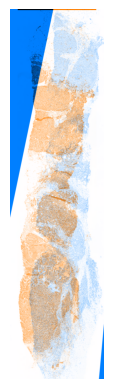

In [27]:
imshow(over_base)

In [379]:
cv2.imshow('aligned', cv2.warpPerspective(wrap_p63.obj_at_lvl([4], 5), warp_p63_direct, (src1.shape[1], src1.shape[0]), flags=cv2.INTER_LANCZOS4 + cv2.WARP_INVERSE_MAP))
# cv2.imshow('ori', wrap_p63.obj_at_lvl([4], 5))
cv2.imshow('target', wrap_sish.obj_at_lvl([5],6))
cv2.waitKey(0)

-1

In [390]:
mapping = np.zeros((src1.shape[0],src1.shape[1],3))

mapping[:,:,1] = np.where(mask_ecad_aligned, 255, 0)
mapping[:,:,2] = np.where(mask_p63_aligned, 255, 0)

cv2.imshow("map",mapping)
cv2.waitKey(0)

-1

In [46]:
warp_inter = None
el = 4
lvl = 5
for lvl in [7,6,5]:
    src1 = wrap_p63.obj_at_lvl([el], lvl)
    src2 = wrap_ecad.obj_at_lvl([el], lvl)
    gray1 = cv2.cvtColor(src1, cv2.COLOR_RGBA2GRAY)
    gray2 = cv2.cvtColor(src2, cv2.COLOR_RGBA2GRAY)
    (cc, warp_inter) = utils.get_warp(gray1, gray2, base=warp_inter)
    print(cc)

0.9375911652582555
0.8930632762076965
0.8091880016717274


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


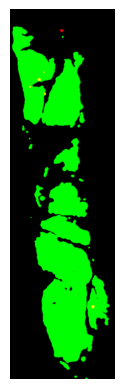

In [50]:
mask_ecad = wrap_mask_at_lvl(wrap_ecad, [4], 4)
mask_p63 = wrap_mask_at_lvl(wrap_p63, [4], 4)

src1 = wrap_p63.obj_at_lvl([4], 4)
src2 = wrap_ecad.obj_at_lvl([4], 4)
gray1 = cv2.cvtColor(src1, cv2.COLOR_RGBA2GRAY)
gray2 = cv2.cvtColor(src2, cv2.COLOR_RGBA2GRAY)
(cc, warp_inter) = utils.get_warp(gray1, gray2, base=warp_inter)

mask_ecad_inter = cv2.warpPerspective(mask_ecad, warp_inter, (src1.shape[1], src1.shape[0]), flags=cv2.INTER_LANCZOS4 + cv2.WARP_INVERSE_MAP)

mapping_inter = np.zeros((src1.shape[0],src1.shape[1],3))

mask_p63 = cv2.dilate(mask_p63, np.full((5,5), 1))
mapping_inter[:,:,0] = np.where(mask_p63, 255, 0)
mapping_inter[:,:,1] = np.where(mask_ecad_inter, 255, 0)

imshow(mapping_inter)

In [397]:
# cv2.imshow("map",mapping)
cv2.imshow("map",cv2.warpPerspective(mapping_inter, warp_p63_direct, (wrap_sish.obj_at_lvl([6], 6).shape[1], wrap_sish.obj_at_lvl([6], 6).shape[0]), flags=cv2.INTER_LANCZOS4 + cv2.WARP_INVERSE_MAP))
cv2.imshow("target",wrap_sish.obj_at_lvl([6], 6))
cv2.waitKey(0)

-1

# VALIS test

In [1]:
import cv2, os
import numpy as np

import importlib

import handling
import utils

In [2]:
import valis

In [3]:
valis.registration.init_jvm()

SLF4J: Failed to load class "org.slf4j.impl.StaticLoggerBinder".
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See http://www.slf4j.org/codes.html#StaticLoggerBinder for further details.


JVM has been initialized. Be sure to call registration.kill_jvm() or slide_io.kill_jvm() at the end of your script.


In [4]:
path_shared = "/mnt/d/uni/THESIS/09816"

path_ecad = path_shared+"/VE0D6A800067E3.mrxs"
wrap_ecad = handling.mrxs_wrapper(path_ecad)
path_p63 = path_shared+"/VE0D6A800067E4.mrxs"
wrap_p63 = handling.mrxs_wrapper(path_p63)
path_sish = path_shared+"/VE0D6A800069B1.mrxs"
wrap_sish = handling.mrxs_wrapper(path_sish)

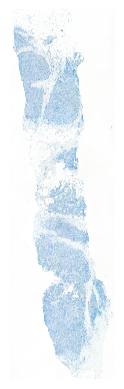

In [10]:
imshow(wrap_p63.obj_at_lvl([4],2))

In [23]:
valis.slide_io.save_ome_tiff(wrap_sish.obj_at_lvl([5],4), path_shared+'/crops/VE0D6A800069B1_groi.ome.tiff', tile_wh=512, compression='lzw')
valis.slide_io.save_ome_tiff(wrap_ecad.obj_at_lvl([4],3), path_shared+'/crops/VE0D6A800067E3_groi.ome.tiff', tile_wh=512, compression='lzw')
valis.slide_io.save_ome_tiff( wrap_p63.obj_at_lvl([4],3), path_shared+'/crops/VE0D6A800067E4_groi.ome.tiff', tile_wh=512, compression='lzw')

saving /mnt/d/uni/THESIS/09816/crops/VE0D6A800069B1_groi.ome.tiff (1176 x 5568 and 4 channels)

[====================================================================================================] 100.0% in 1.01 seconds
Complete

saving /mnt/d/uni/THESIS/09816/crops/VE0D6A800067E3_groi.ome.tiff (1472 x 5024 and 4 channels)

[====================================================================================================] 100.0% in 0.886 seconds
Complete

saving /mnt/d/uni/THESIS/09816/crops/VE0D6A800067E4_groi.ome.tiff (1408 x 4992 and 4 channels)

[====================================================================================================] 100.0% in 0.853 seconds
Complete



In [20]:
cv2.imwrite(path_shared+'/crops/VE0D6A800069B1_groi.ome.tiff', wrap_sish.obj_at_lvl([5],3))

KeyboardInterrupt: 

In [11]:
registrar = valis.registration.Valis(path_shared+'/crops', 'temp/', max_processed_image_dim_px=1200,
                                     reference_img_f=path_shared+'/crops/VE0D6A800069B1_groi.ome.tiff')

/home/scalestrix/miniconda3/envs/her2/lib/python3.10/site-packages/valis/valtils.py:21: UserWarning: Can't find slide file associated with xtra
  warnings.warn(warning_msg, warning_type)
/home/scalestrix/miniconda3/envs/her2/lib/python3.10/site-packages/valis/valtils.py:21: UserWarning: max_image_dim_px is 850 but needs to be less or equal to 1200. Setting max_image_dim_px to 1200
  warnings.warn(warning_msg, warning_type)


In [12]:
registrar.name_dict

{'/mnt/d/uni/THESIS/09816/crops/VE0D6A800067E3_groi.ome.tiff': 'VE0D6A800067E3_groi',
 '/mnt/d/uni/THESIS/09816/crops/VE0D6A800067E4_groi.ome.tiff': 'VE0D6A800067E4_groi',
 '/mnt/d/uni/THESIS/09816/crops/VE0D6A800069B1_groi.ome.tiff': 'VE0D6A800069B1_groi'}

In [13]:
rigid_registrar, non_rigid_registrar, summary_df = registrar.register()


==== Converting images



  0%|                                                                                             | 0/3 [00:00<?, ?it/s]

No series provided. Selecting series with largest image, which is series 0
Converting slide to pyvips image



 33%|████████████████████████████▎                                                        | 1/3 [00:04<00:08,  4.38s/it]

No series provided. Selecting series with largest image, which is series 0
Converting slide to pyvips image



 67%|████████████████████████████████████████████████████████▋                            | 2/3 [00:07<00:03,  3.63s/it]

No series provided. Selecting series with largest image, which is series 0
Converting slide to pyvips image



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:10<00:00,  3.53s/it]
/home/scalestrix/miniconda3/envs/her2/lib/python3.10/site-packages/valis/valtils.py:21: UserWarning: Smallest image is less than max_image_dim_px. parameter max_image_dim_px is being set to 624
  warnings.warn(warning_msg, warning_type)
/home/scalestrix/miniconda3/envs/her2/lib/python3.10/site-packages/valis/valtils.py:21: UserWarning: parameter max_processed_image_dim_px also being updated to 624
  warnings.warn(warning_msg, warning_type)



==== Processing images



  0%|                                                                                             | 0/3 [00:00<?, ?it/s]

No series provided. Selecting series with largest image, which is series 0


/home/scalestrix/miniconda3/envs/her2/lib/python3.10/site-packages/valis/valtils.py:21: UserWarning: Cannot find channel 'dapi' in /mnt/d/uni/THESIS/09816/crops/VE0D6A800067E3_groi.ome.tiff. Using channel 0
  warnings.warn(warning_msg, warning_type)
 33%|████████████████████████████▎                                                        | 1/3 [00:01<00:02,  1.46s/it]

No series provided. Selecting series with largest image, which is series 0


/home/scalestrix/miniconda3/envs/her2/lib/python3.10/site-packages/valis/valtils.py:21: UserWarning: Cannot find channel 'dapi' in /mnt/d/uni/THESIS/09816/crops/VE0D6A800067E4_groi.ome.tiff. Using channel 0
  warnings.warn(warning_msg, warning_type)
 67%|████████████████████████████████████████████████████████▋                            | 2/3 [00:02<00:01,  1.40s/it]

No series provided. Selecting series with largest image, which is series 0


/home/scalestrix/miniconda3/envs/her2/lib/python3.10/site-packages/valis/valtils.py:21: UserWarning: Cannot find channel 'dapi' in /mnt/d/uni/THESIS/09816/crops/VE0D6A800069B1_groi.ome.tiff. Using channel 0
  warnings.warn(warning_msg, warning_type)
100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.38s/it]



==== Normalizing images



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.02it/s]



==== Rigid registraration



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 25.20it/s]
/home/scalestrix/miniconda3/envs/her2/lib/python3.10/site-packages/valis/valtils.py:21: UserWarning: ('The reference was specified as VE0D6A800069B1_groi ', 'but `align_to_reference` is `False`, and so images will be aligned serially. ', 'If you would like all images to be directly aligned to VE0D6A800069B1_groi, then set `align_to_reference` to `True`')
  warnings.warn(warning_msg, warning_type)



======== Detecting features



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.71s/it]



======== Matching images



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.31s/it]



======== Sorting images


======== Calculating transformations



100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 897.31it/s]



======== Rigid registration complete in 12.221 seconds


==== Non-rigid registraration


======== Preparing images for non-rigid registration



  0%|                                                                                             | 0/3 [00:00<?, ?it/s]

Converting slide to pyvips image



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 101.47it/s]


No series provided. Selecting series with largest image, which is series 0


/home/scalestrix/miniconda3/envs/her2/lib/python3.10/site-packages/valis/valtils.py:21: UserWarning: Cannot find channel 'dapi' in /mnt/d/uni/THESIS/09816/crops/VE0D6A800067E3_groi.ome.tiff. Using channel 0
  warnings.warn(warning_msg, warning_type)
 33%|████████████████████████████▎                                                        | 1/3 [00:03<00:06,  3.16s/it]

Converting slide to pyvips image



100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 3437.95it/s]


No series provided. Selecting series with largest image, which is series 0


/home/scalestrix/miniconda3/envs/her2/lib/python3.10/site-packages/valis/valtils.py:21: UserWarning: Cannot find channel 'dapi' in /mnt/d/uni/THESIS/09816/crops/VE0D6A800067E4_groi.ome.tiff. Using channel 0
  warnings.warn(warning_msg, warning_type)
 67%|████████████████████████████████████████████████████████▋                            | 2/3 [00:06<00:03,  3.53s/it]

Converting slide to pyvips image



100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 3494.09it/s]


No series provided. Selecting series with largest image, which is series 0


/home/scalestrix/miniconda3/envs/her2/lib/python3.10/site-packages/valis/valtils.py:21: UserWarning: Cannot find channel 'dapi' in /mnt/d/uni/THESIS/09816/crops/VE0D6A800069B1_groi.ome.tiff. Using channel 0
  warnings.warn(warning_msg, warning_type)
100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:10<00:00,  3.47s/it]
/home/scalestrix/miniconda3/envs/her2/lib/python3.10/site-packages/valis/valtils.py:21: UserWarning: ('The reference was specified as VE0D6A800069B1_groi ', 'but `align_to_reference` is `False`, and so images will be aligned serially. ', 'If you would like all images to be directly aligned to VE0D6A800069B1_groi, then set `align_to_reference` to `True`')
  warnings.warn(warning_msg, warning_type)
100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.56s/it]



======== Non-rigid registration complete in 9.533 seconds


==== Measuring error



100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.26it/s]


In [14]:
summary_df

,filename,from,to,original_D,original_rTRE,rigid_D,rigid_rTRE,non_rigid_D,non_rigid_rTRE,processed_img_shape,shape,aligned_shape,mean_original_D,mean_rigid_D,physical_units,resolution,name,rigid_time_minutes,mean_non_rigid_D,non_rigid_time_minutes
0,/mnt/d/uni/THESIS/09816/crops/VE0D6A800069B1_g...,VE0D6A800069B1_groi,None,NaN,NaN,NaN,NaN,NaN,NaN,"(624, 132)","(5568, 1176)","(5568, 2058)",113.494166,13.195275,px,1.0,crops,0.459314,12.833035,0.836013
1,/mnt/d/uni/THESIS/09816/crops/VE0D6A800067E4_g...,VE0D6A800067E4_groi,VE0D6A800069B1_groi,337.353352,0.528926,41.301262,0.064755,34.179826,0.064755,"(624, 176)","(4992, 1408)","(5568, 2058)",113.494166,13.195275,px,1.0,crops,0.459314,12.833035,0.836013
2,/mnt/d/uni/THESIS/09816/crops/VE0D6A800067E3_g...,VE0D6A800067E3_groi,VE0D6A800067E4_groi,99.222633,0.155568,11.403455,0.017879,11.472129,0.017879,"(624, 183)","(5024, 1472)","(5568, 2058)",113.494166,13.195275,px,1.0,crops,0.459314,12.833035,0.836013


In [15]:
import pandas as pd

In [16]:
registrar.slide_dict

{'VE0D6A800067E3_groi': <valis.registration.Slide at 0x7f154b6be770>,
 'VE0D6A800067E4_groi': <valis.registration.Slide at 0x7f154b6bd210>,
 'VE0D6A800069B1_groi': <valis.registration.Slide at 0x7f14d83c13f0>}

In [17]:
warped_ecad = registrar.slide_dict['VE0D6A800067E3_groi'].warp_img(wrap_ecad.obj_at_lvl([4],3))
warped_p63  = registrar.slide_dict['VE0D6A800067E4_groi'].warp_img( wrap_p63.obj_at_lvl([4],3))
warped_sish = registrar.slide_dict['VE0D6A800069B1_groi'].warp_img(wrap_sish.obj_at_lvl([5],4))

/home/scalestrix/miniconda3/envs/her2/lib/python3.10/site-packages/valis/valtils.py:21: UserWarning: scaling transformation for image with different shape. However, without knowing all of other image's shapes, the scaling may not be the same for all images, and somay not overlap.
  warnings.warn(warning_msg, warning_type)
/home/scalestrix/miniconda3/envs/her2/lib/python3.10/site-packages/valis/valtils.py:21: UserWarning: scaling transformation for image with different shape. However, without knowing all of other image's shapes, the scaling may not be the same for all images, and somay not overlap.
  warnings.warn(warning_msg, warning_type)
/home/scalestrix/miniconda3/envs/her2/lib/python3.10/site-packages/valis/valtils.py:21: UserWarning: scaling transformation for image with different shape. However, without knowing all of other image's shapes, the scaling may not be the same for all images, and somay not overlap.
  warnings.warn(warning_msg, warning_type)


In [62]:
cv2.imwrite(path_shared+'/crops/VE0D6A800067E3_warp.png', warped_ecad)
cv2.imwrite(path_shared+'/crops/VE0D6A800067E4_warp.png',  warped_p63)
cv2.imwrite(path_shared+'/crops/VE0D6A800069B1_warp.png', warped_sish)

True

In [87]:
growth_iter = 5
hit_kernel = np.array([[0,0,0],
                       [0,1,0],
                       [0,0,0]], np.uint8)
miss_kernel = np.array([[1,1,1],
                        [1,0,1],
                        [1,1,1]], dtype=np.uint8)

def mask_dye(img):
    return cv2.inRange(img, (0,8,8), (40,224,160)) + cv2.inRange(img, (155,8,8), (179,224,160))

def expand_mask(mask):
    hit = cv2.morphologyEx(mask, cv2.MORPH_ERODE, hit_kernel)
    miss = cv2.morphologyEx(cv2.bitwise_not(mask), cv2.MORPH_ERODE, miss_kernel)
    hitormiss = cv2.bitwise_and(hit, miss)
    mask = mask - hitormiss
    
    mask = cv2.dilate(mask, np.full((9,9),1))
    for i in range(growth_iter):
        mask = cv2.medianBlur(mask, 7)
    mask = cv2.erode(mask, np.full((5,5),1))
    return mask

def create_mask(img):
    mask = mask_dye(img)
    mask = expand_mask(mask)
    return mask

def wrap_mask_at_lvl(wrap, loc, lvl):
    obj = wrap.obj_at_lvl(loc, lvl)
    obj = cv2.cvtColor(obj, cv2.COLOR_RGB2HSV)
    mask = mask_dye(obj)
    mask = expand_mask(mask)
    return mask

In [19]:
warped_ecad.shape

(5024, 1061, 4)

In [20]:
mask_ecad = wrap_mask_at_lvl(wrap_ecad, [4], 3)
mask_p63 =  wrap_mask_at_lvl(wrap_p63,  [4], 3)

mask_warped_ecad = registrar.slide_dict['VE0D6A800067E3_groi'].warp_img(mask_ecad)
mask_warped_p63  = registrar.slide_dict['VE0D6A800067E4_groi'].warp_img( mask_p63)

/home/scalestrix/miniconda3/envs/her2/lib/python3.10/site-packages/valis/valtils.py:21: UserWarning: scaling transformation for image with different shape. However, without knowing all of other image's shapes, the scaling may not be the same for all images, and somay not overlap.
  warnings.warn(warning_msg, warning_type)
/home/scalestrix/miniconda3/envs/her2/lib/python3.10/site-packages/valis/valtils.py:21: UserWarning: scaling transformation for image with different shape. However, without knowing all of other image's shapes, the scaling may not be the same for all images, and somay not overlap.
  warnings.warn(warning_msg, warning_type)


In [21]:
mask_warped_ecad.shape

(5024, 1061)

In [22]:
mask_warped_p63.shape

(4992, 1056)

In [23]:
warped_sish.shape

(5568, 1176, 4)

In [46]:
cv2.imwrite(path_shared+'/crops/ecad_warpedmask.png', mask_warped_ecad)
cv2.imwrite(path_shared+ '/crops/p63_warpedmask.png',  mask_warped_p63)

True

# Local maps

In [109]:
outs = dict()
target_xywh = [400, 1400, 300, 400]
for slide in registrar.slide_dict:
    warped = registrar.slide_dict[slide].warp_slide(0)
    warped_img = warped.extract_area(*target_xywh)
    outs[slide] = warped_img.numpy()

Converting slide to pyvips image


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.69it/s]


Converting slide to pyvips image


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.09it/s]


Converting slide to pyvips image


100%|███████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.08it/s]


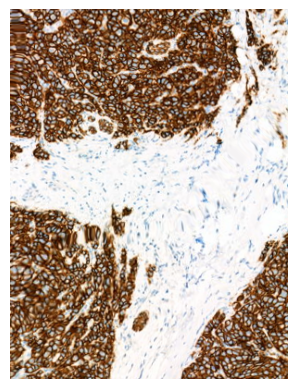

In [110]:
imshow(outs['VE0D6A800067E3_groi'])

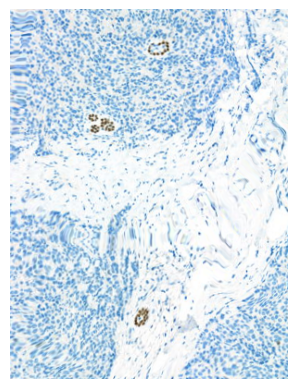

In [111]:
imshow(outs['VE0D6A800067E4_groi'])

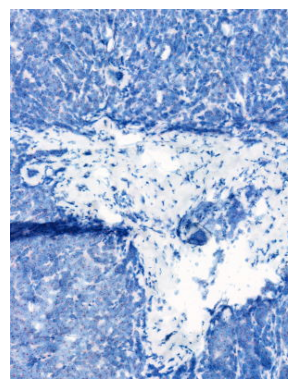

In [112]:
imshow(outs['VE0D6A800069B1_groi'])

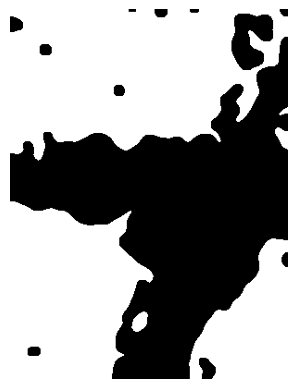

In [113]:
mask_test_ecad = create_mask(outs['VE0D6A800067E3_groi'][:,:,:3])
imshow(mask_test_ecad)

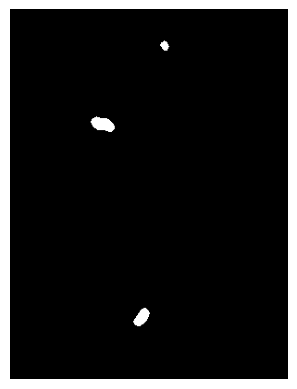

In [114]:
mask_test_p63 = create_mask(outs['VE0D6A800067E4_groi'][:,:,:3])
imshow(mask_test_p63)

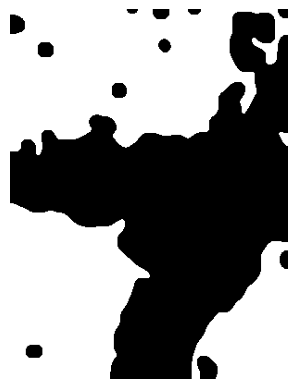

In [115]:
map_test = cv2.erode(mask_test_ecad - mask_test_p63, np.full((5,5), 1))
map_test = cv2.medianBlur(map_test, 7)
imshow(map_test)

In [116]:
target_xywh

[400, 1400, 300, 400]

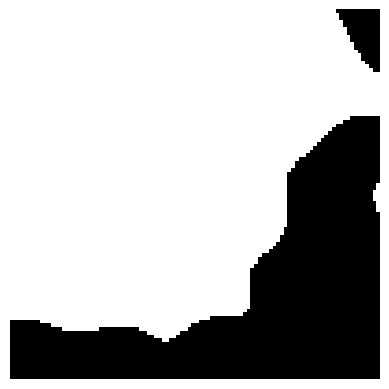

In [249]:
imshow(map_test[50:150,150:250])

In [250]:
# sish aligner was from level 4
new_target_xywh = [550, 1450, 100, 100]
target_tile_coord = wrap_sish._convert_scale_from_to(new_target_xywh,4,0)
offset = wrap_sish._bounds_at_lvl([5], 0)
target_tile_coord[0] += offset['x']
target_tile_coord[1] += offset['y']
cell_test = np.array(wrap_sish.image.read_region((target_tile_coord[0],target_tile_coord[1]),0,(target_tile_coord[2],target_tile_coord[3])))

# Cell detection

In [251]:
target_tile_coord

array([ 72032, 113056,   1600,   1600], dtype=int32)

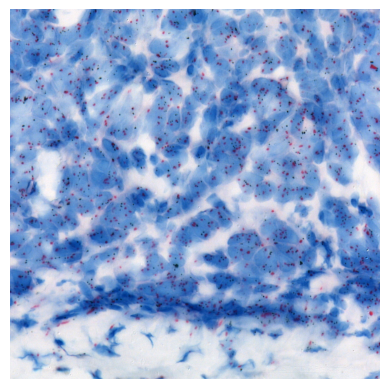

In [252]:
imshow(cell_test[:,:,:])

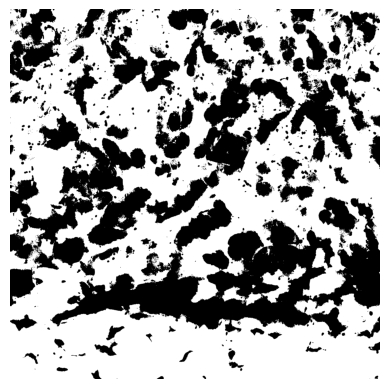

In [256]:
white_mask = np.where(cv2.cvtColor(cell_test[:,:,:3], cv2.COLOR_RGB2GRAY)>144, 255, 0).astype(np.uint8)
# white_mask = cv2.medianBlur(white_mask, 3)
# white_mask = cv2.erode(white_mask, np.full((5,5),1))
# white_mask = cv2.medianBlur(white_mask, 5)
imshow(white_mask)

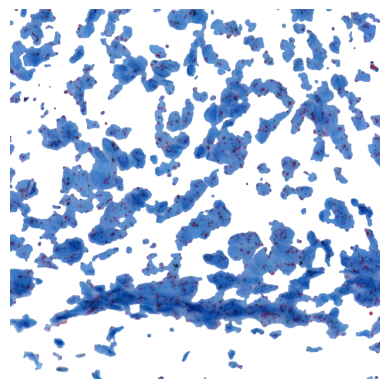

In [400]:
clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize=(4, 4))
claheNorm = clahe.apply(cv2.cvtColor(cell_test[:,:,:3], cv2.COLOR_RGB2GRAY))
clahe_mask = np.where(claheNorm<120,255,0).astype(np.uint8)

clahe_mask = cv2.erode(clahe_mask, np.full((3,3),1))
for i in range(20):
    clahe_mask = cv2.medianBlur(clahe_mask, 5)
clahe_mask = cv2.erode(clahe_mask, np.full((5,5),1))
clahe_mask = cv2.dilate(clahe_mask, np.full((7,7),1))
    
clahe_stack = np.stack([clahe_mask]*4, axis=2)
imshow(np.where(clahe_stack, cell_test, 255))

In [315]:
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(np.where(claheNorm<110,255,0).astype(np.uint8),cv2.MORPH_OPEN,kernel, iterations = 1)

sure_bg = cv2.dilate(opening,kernel,iterations=1)

dist_transform = cv2.distanceTransform(opening,cv2.DIST_L12,0)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

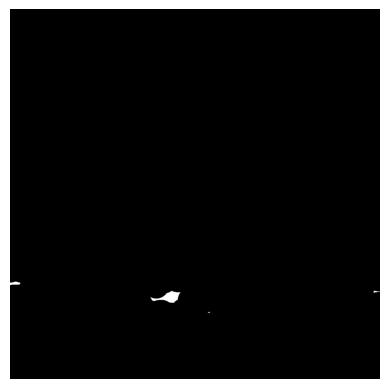

In [316]:
imshow(sure_fg)

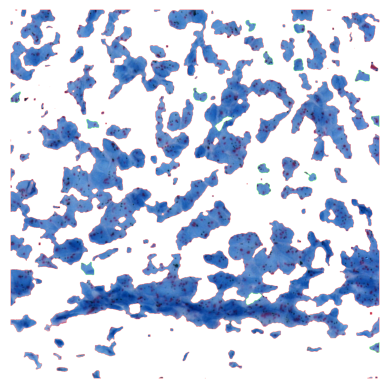

In [406]:
cnts, _ = cv2.findContours(clahe_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
out = np.where(clahe_stack, cell_test, 0).copy()
good = []
for cnt in cnts:
    convex = cv2.convexHull(cnt)
    (x,y),radius = cv2.minEnclosingCircle(cnt)
    if int(radius) in range(16, 40) and int(cv2.contourArea(convex)) in range(1600, 3600):
        out = cv2.drawContours(out, [cnt], -1, (0,255,0), 3)
        good.append(convex)
    else:
        out = cv2.drawContours(out, [cnt], -1, (255,0,0), 3)
imshow(out)

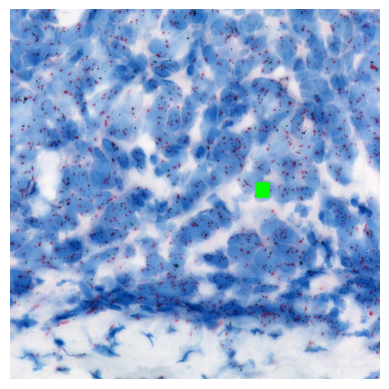

In [413]:
cell_ttt = cell_test.copy()
el = 3
x,y,w,h = cv2.boundingRect(good[el])
cell_ttt[y:y+w,x:x+h,0] = 0
cell_ttt[y:y+w,x:x+h,1] = 255
cell_ttt[y:y+w,x:x+h,2] = 0
imshow(cell_ttt)

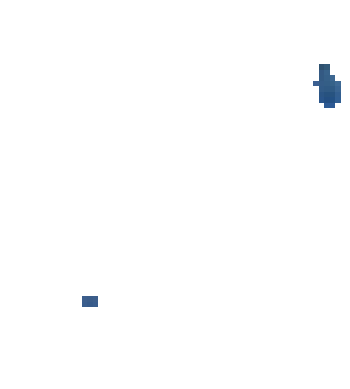

In [452]:
el = 3
x,y,w,h = cv2.boundingRect(good[el])
hsv = cv2.cvtColor(cell_test[y:y+w,x:x+h,:3],cv2.COLOR_RGB2HSV)
mask = cv2.inRange(hsv,(0,144,0),(179,255,150))
mask = np.stack([mask]*4, axis=2)
imshow(np.where(mask, cell_test[y:y+w,x:x+h,:], 0))